## Restaurant reviews simple sentiment analysis

#### Imports and stuff

In [1]:
import pandas as pd
import numpy as np 
import nltk
import matplotlib.pyplot as plt
#nltk.download('punkt')
plt.style.use('ggplot')
from tqdm.notebook import tqdm

In [2]:
df_real = pd.read_csv("C:/Users/costa/Downloads/archive/Restaurant reviews.csv")
df = df_real.copy()

In [3]:
df.columns = [i.lower() for i in df.columns]

#### Quick EDA

EDA stands for Exploratory Data Analysis. Here we just have a quick look at:
- how the data are strucutured with df.head
- if there are any null values in the colums with df.info
- the distribution of the labels with the bar chart

In [4]:
df.head(5)

,restaurant,reviewer,review,rating,metadata,time,pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   restaurant  10000 non-null  object 
 1   reviewer    9962 non-null   object 
 2   review      9955 non-null   object 
 3   rating      9962 non-null   object 
 4   metadata    9962 non-null   object 
 5   time        9962 non-null   object 
 6   pictures    10000 non-null  int64  
 7   7514        1 non-null      float64
dtypes: float64(1), int64(1), object(6)
memory usage: 625.1+ KB


<Axes: xlabel='rating'>

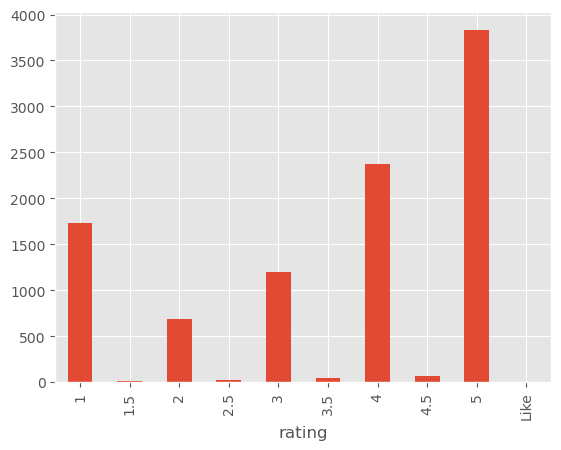

In [6]:
df['rating'].value_counts().sort_index().plot(kind='bar')

## Data Prep

A couple of things are needed before beginning:
- dropping reviews that have 'Like' as response rathern than a number
- converting the rating to a numeric value and rounding it 
- dropping reviews with NaN rating 
- dropping useless features (to make everything smoother)

In [7]:
df.drop(df[df['rating']=='Like'].index, inplace = True)
df.dropna(subset = 'review', inplace=True)
df.reset_index(inplace=True)
df.drop(['reviewer', 'metadata', 'time', 'pictures', '7514'], axis = 1, inplace=True)

In [8]:
df['rating'] = pd.to_numeric(df['rating'])
df['rating'] = df['rating'].round(0)

In [9]:
df.head()

,index,restaurant,review,rating
0,0,Beyond Flavours,"The ambience was good, food was quite good . h...",5.0
1,1,Beyond Flavours,Ambience is too good for a pleasant evening. S...,5.0
2,2,Beyond Flavours,A must try.. great food great ambience. Thnx f...,5.0
3,3,Beyond Flavours,Soumen das and Arun was a great guy. Only beca...,5.0
4,4,Beyond Flavours,Food is good.we ordered Kodi drumsticks and ba...,5.0


#### Text prep

To analyze text data we need first to pre-process it in a way that makes it more interpretable for machines.

The function data_cleaner does the following things:
- converts every character to lowercase
- removes punctuation
- removes urls (cannot be interpreted as words)
- removes line breaks '\n'
- removes stopwords like 'it', 'the' which do not have much value for our models
- changes the words to their 'easiest' form ([stem](https://en.wikipedia.org/wiki/Word_stem)) with [PorterStemmer](https://tartarus.org/martin/PorterStemmer/)

In [10]:
import re
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string

stopword=set(stopwords.words('english'))

def data_cleaner(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = text.split()
    
    #Removing stopwords.
    text = [word for word in text if not word in stopword]
    
    #Stemming.
    ps = PorterStemmer()
    text = [ps.stem(word) for word in text]
    
    #List to string.
    text = ' '.join(text)
    
    return text  

In [11]:
df['review_clean'] = df['review'].apply(data_cleaner)

In [12]:
df.head()

,index,restaurant,review,rating,review_clean
0,0,Beyond Flavours,"The ambience was good, food was quite good . h...",5.0,ambienc good food quit good saturday lunch cos...
1,1,Beyond Flavours,Ambience is too good for a pleasant evening. S...,5.0,ambienc good pleasant even servic prompt food ...
2,2,Beyond Flavours,A must try.. great food great ambience. Thnx f...,5.0,must tri great food great ambienc thnx servic ...
3,3,Beyond Flavours,Soumen das and Arun was a great guy. Only beca...,5.0,soumen da arun great guy behavior sincereti go...
4,4,Beyond Flavours,Food is good.we ordered Kodi drumsticks and ba...,5.0,food goodw order kodi drumstick basket mutton ...


Since the dataset is very big for the rest of the cose I'll just use a subsample of 500 restaurant. Clearly the best thing would be to use all the data available but I'm not a patient guy so i'll just assume that is the whole dataset :)

In [13]:
data = df.head(500).copy()

## Models

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
X = data['review_clean']
y = data['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Before applying any model we need to transform the reviews in a form that can be understood by machine: numbers (vectors more specifically). \
To do this I use [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [16]:
vectorizer = TfidfVectorizer(min_df=3).fit(X_train)
X_vectors = vectorizer.transform(X_train)

#### Random Forest Regression

This is a particular kind of problem because it is a [multi-class classification](https://en.wikipedia.org/wiki/Multiclass_classification) problem, but classes have ordinal properties -> 5 is not only different from 4 but also "better" than 4.\
The simplest approach is this case is to treat it like a regression and then round the predicted values.

In the following code I just train a simple random forest regressor.\
When trained "out-of-the-box" the model performs very poorly. Luckily we can improve the performance tuning parameters through [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)).\
In particular here I use [GridSearchCV](sklearn.model_selection.GridSearchCV)

In [17]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state = 42)
model.fit(X_vectors, y_train)

RandomForestRegressor(random_state=42)

In [18]:
X_vectors_test = vectorizer.transform(X_test)
pred = model.predict(X_vectors_test)
pred = np.round(pred)

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        11
         2.0       0.12      0.50      0.20         2
         3.0       0.18      0.22      0.20         9
         4.0       0.24      0.33      0.28        24
         5.0       0.81      0.73      0.77        79

    accuracy                           0.55       125
   macro avg       0.27      0.36      0.29       125
weighted avg       0.57      0.55      0.56       125



C:\Users\costa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\costa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\costa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
from sklearn.model_selection import GridSearchCV
params = {'criterion':['squared_error', 'absolute_error'], 'max_depth':[2, 7, 15], 'max_leaf_nodes':[2, 20]}

gsc = GridSearchCV(estimator=RandomForestRegressor(random_state = 42), param_grid=params, cv=5, scoring='neg_mean_squared_error')
scores = gsc.fit(X_vectors, y_train)

In [21]:
print(f'best parameters: {scores.best_params_}')

best parameters: {'criterion': 'squared_error', 'max_depth': 15, 'max_leaf_nodes': 20}


In [22]:
best = scores.best_estimator_
pred = best.predict(X_vectors_test)
pred = np.round(pred)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        11
         2.0       0.14      0.50      0.22         2
         3.0       0.15      0.22      0.18         9
         4.0       0.26      0.33      0.29        24
         5.0       0.81      0.76      0.78        79

    accuracy                           0.57       125
   macro avg       0.27      0.36      0.30       125
weighted avg       0.58      0.57      0.57       125



C:\Users\costa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\costa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\costa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Try yourself

Can you do better?\
Here are a few ideas on how this can be improed:
- try other models, maybe simpler one (e.g [linear regression](https://en.wikipedia.org/wiki/Linear_regression) or more complex ones (e.g. [GradientBoosting](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html), [Support Vector Machine](https://en.wikipedia.org/wiki/Support_vector_machine) regression)
- try to use all the data (warning: training the models may take a while)
- try to spot any mistakes I did in this process (e.g. Is it correct to use the first 500 observation? Can accuracy be improved by a random sample from the dataset? )
- (more advanced) try to use other strategies for ordinal regression (e.g. [ordered logit](https://en.wikipedia.org/wiki/Ordered_logit))

#### VADER

In this section I try to tackle this task using a pre-trained model called [VADER](https://github.com/cjhutto/vaderSentiment).\
VADER is a simple bag of words approach that computes the positivity/negativity score for each word individually, based on a bag of words --> this means context is not analysed.\
VADER uses a set of [heuristics](https://medium.com/@piocalderon/vader-sentiment-analysis-explained-f1c4f9101cd9) which in part rely on stopwords and puctuation, for this reason the data that we feed the model shouldn't be pre-processed as before

From the plot at the end of the section we can see that the model has correclty recognised the review we have in fact that:
- the average score for reviews with rating 1 is negative
- the average score for reviews with rating 5 is very postive
- the overall ranking between the rating was correctly identified

The output of this model is slightly differetn than the previous ones. VADER in fact is used for [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) that means insteadof predicting our rating it just understands whether a sentence is postive or negative. Then to predicti our labels we can either set thersholds and assign a rating based on those (e.g. if <0.1 rating = 1, if > 0.8 rating = 5) or use the scores returned by the model as features for another machine learning algorithm.

In [23]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [24]:
from sklearn.utils import resample
data_vader = resample(df, n_samples=2000, replace=False, random_state=42)
data_vader.loc[0].review

'The ambience was good, food was quite good . had Saturday lunch , which was cost effective .\nGood place for a sate brunch. One can also chill with friends and or parents.\nWaiter Soumen Das was really courteous and helpful.'

In [25]:
sia.polarity_scores(data_vader.loc[0].review)

{'neg': 0.0, 'neu': 0.582, 'pos': 0.418, 'compound': 0.9664}

In [26]:
res = {}
for i, row in tqdm(data_vader.iterrows(), total = len(data_vader)):
    try:
        text = row['review']
        score = sia.polarity_scores(text)
        res[i] = {**score, **{'text':text}}
    except AttributeError:
        print(f'error for {text}')

  0%|          | 0/2000 [00:00<?, ?it/s]

In [27]:
pred = []
for i in res:
    pred.append(res[i]['compound'])

In [28]:
data_vader['pred'] = pd.to_numeric(pred)
err = sum((data_vader['pred']-data_vader['rating'])**2)/len(df)
print(f'mean squared error: {err}')

mean squared error: 2.215509865341572


From this plot we can see that the compound scores predicted by the model are actually consistent with the rating, we have indeed that for the score is very low for rating=1 and it increases for higher values of rating.

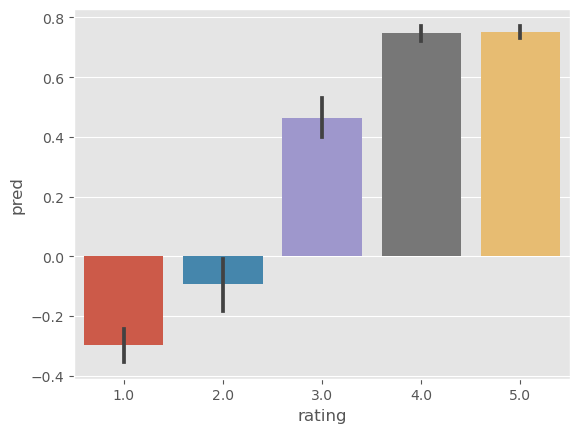

In [29]:
import seaborn as sns
ax = sns.barplot(data=data_vader, x='rating', y='pred')
plt.show()

In [30]:
neg = []
pos = []
neu = []
for i in res:
    neg.append(res[i]['neg'])
    pos.append(res[i]['pos'])
    neu.append(res[i]['neu'])

In [31]:
data_vader_agg = data_vader[['restaurant', 'rating']].copy()

In [32]:
data_vader_agg['pos_score'] = pos
data_vader_agg['neg_score'] = neg
data_vader_agg['neu_score'] = neu

In [33]:
data_vader_agg = pd.concat([data_vader_agg[['pos_score', 'neg_score', 'neu_score']], pd.get_dummies(data_vader_agg['restaurant'])], axis = 1)

In [34]:
from sklearn.model_selection import train_test_split 
y = data_vader['rating'].copy()
X_train, X_test, y_train, y_test = train_test_split(data_vader_agg, y, random_state=42)

In [35]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state = 42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [36]:
from sklearn.metrics import classification_report
pred = model.predict(X_test)
pred = np.round(pred)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         1.0       0.59      0.26      0.36        91
         2.0       0.15      0.24      0.18        37
         3.0       0.15      0.22      0.18        54
         4.0       0.42      0.49      0.45       134
         5.0       0.69      0.61      0.65       184

    accuracy                           0.45       500
   macro avg       0.40      0.37      0.37       500
weighted avg       0.50      0.45      0.46       500



#### Try this 

Can you do better? Try to tune parameters or other models

### Using pretrained HuggingFace model

In this section I use a pretrained BERT model. It is also possible to fine-tune a BERT model ([see here](https://github.com/vanderbilt-data-science/bigdata/blob/main/06-fine-tune-BERT-on-our-dataset.ipynb))\
In this case I chose a "RoBERTa-base model trained on ~124M tweets" [more here](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest). More models can be found on the [HuggingFace](https://huggingface.co/models) website

The code that follows is used to:
- load the weights of a pretrained model that are used for prediction
- turn text into tensotrs to be used by the mdel, using the function tokenizer (also this is pretrained)

Same as before this instead of assigning the review to a certain rating, roBERTa just computes negativity, positivity and neutrality scores.

In [37]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import RobertaModel
from scipy.special import softmax

In [38]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
def roberta_model(ex):
    enc_txt = tokenizer(ex, return_tensors='pt')
    output = model(**enc_txt)
    a = output[0][0].detach().numpy()
    b = softmax(a)
    res_dict = {
        'roberta_neg' : b[0],
        'roberta_neu' : b[1],
        'roberta_pos' : b[2]
    }
    return res_dict

In [40]:
data_roberta = resample(df, n_samples=500, replace=False, random_state=42)

In [41]:
roberta_model(data_roberta.iloc[0].review)

{'roberta_neg': 0.7178459, 'roberta_neu': 0.2618411, 'roberta_pos': 0.02031299}

Warning: the for loop in the next cell is slow af

In [42]:
res = {}
for i, row in tqdm(data_roberta.iterrows(), total=len(data_roberta)):
    try:
        text = row['review']
        res_dict = roberta_model(text)
        res[i] = {**res_dict, **{'text':text}}
    except:
        print(f'error for {text}')

  0%|          | 0/500 [00:00<?, ?it/s]

error for I wanted to make my adjustments in my food habits and was looking for genuine healthy options around Gachibowli. I did my little research and understood that many products which are being sold as healthy are nothing but just great marketing tricks amidst all of this chaos a newly opened food chain by name eat-fit was my saviour. This was the only place which mentioned the calorific value precisely which is very rare in case of freshly prepared food in India. Few reasons why eat-fit is better than other places 

1) They do not use any processed ingredients 
2) They do daily sourcing of veggies & meats ( That's the real secret for the consistent taste) 
3) They use less amount of oil compared to any other joint in the market 
4) NO Maida No Sugar what so ever in any of their dishes 
5) Daily Cooking (They cook a limited number of portions )
and there are various other reasons as well 

The calorie count does help me keep my weight in check and the best part is all the Indian me

In [43]:
roberta_pos = []
roberta_neg = []
roberta_neu = []
for i in res:
    roberta_pos.append(res[i]['roberta_pos'])
    roberta_neg.append(res[i]['roberta_neg'])
    roberta_neu.append(res[i]['roberta_neu'])

From this plot we can see that the compound scores predicted by the model are actually consistent with the rating, we have indeed that for the score is very low for rating=1 and it increases for higher values of rating.

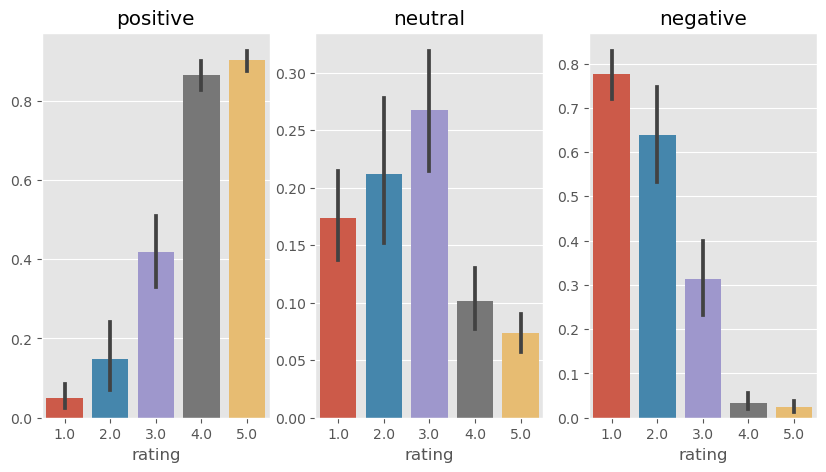

In [44]:
import seaborn as sns
valid = data_roberta[data_roberta['review'].apply(lambda x: True if len(x)<2000 else False)]
fig, axs = plt.subplots(ncols=3, figsize=(10, 5))
sns.barplot(x = valid['rating'] , y=roberta_pos, ax=axs[0]).set_title('positive')
sns.barplot(x = valid['rating'] , y=roberta_neu, ax=axs[1]).set_title('neutral')
sns.barplot(x = valid['rating'] , y=roberta_neg, ax=axs[2]).set_title('negative')
plt.show()